# Field Sampling


The particle trajectories allow us to study fields like temperature, plastic concentration or chlorophyll from a Lagrangian perspective.

In this tutorial we will go through how particles can sample `Fields`, using temperature as an example. Along the way we will get to know the parcels class `Variable` (see [here](https://parcels.readthedocs.io/en/latest/reference/particles.html#parcels.particle.Variable) for the documentation) and some of its methods. This tutorial covers several applications of a sampling setup:

- [**Basic along trajectory sampling**](#Basic-sampling)
- [**Sampling velocity fields**](#Sampling-velocity-fields)
- [**Sampling initial conditions**](#Sampling-initial-values)


## Basic sampling

We import both the packages that we need to set up the simulation, as well as the parcels package.


In [1]:
# Modules needed for the Parcels simulation
from datetime import timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# To open and look at the temperature data
import xarray as xr

import parcels

Suppose we want to study the environmental temperature for plankton drifting around a peninsula. We have a dataset with surface ocean velocities and the corresponding sea surface temperature stored in netcdf files in the folder `"Peninsula_data"`. Besides the velocity fields, we load the temperature field using `extra_fields={'T': 'T'}`. The particles are released on the left hand side of the domain.


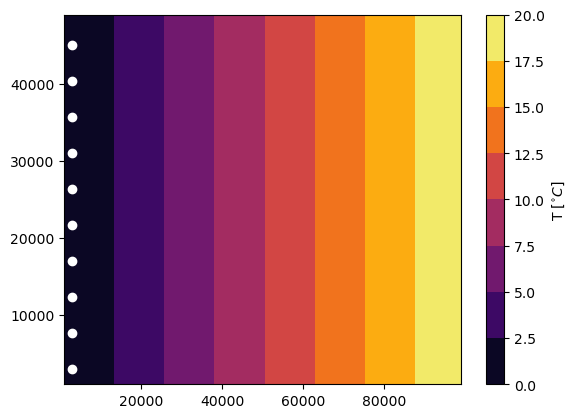

In [2]:
# Velocity and temperature fields
example_dataset_folder = parcels.download_example_dataset("Peninsula_data")
fieldset = parcels.FieldSet.from_parcels(
    f"{example_dataset_folder}/peninsula",
    extra_fields={"T": "T"},
    allow_time_extrapolation=True,
)

# Particle locations and initial time
npart = 10  # number of particles to be released
lon = 3e3 * np.ones(npart)
lat = np.linspace(3e3, 45e3, npart, dtype=np.float32)
time = (
    np.arange(0, npart) * timedelta(hours=2).total_seconds()
)  # release each particle two hours later

# Plot temperature field and initial particle locations
T_data = xr.open_dataset(f"{example_dataset_folder}/peninsulaT.nc")
plt.figure()
ax = plt.axes()
T_contour = ax.contourf(
    T_data.x.values, T_data.y.values, T_data.T.values[0, 0], cmap=plt.cm.inferno
)
ax.scatter(lon, lat, c="w")
plt.colorbar(T_contour, label=r"T [$^{\circ} C$]")
plt.show()

To sample the temperature field, we need to create a new class of particles where temperature is a `Variable`. We then also need a new Kernel `SampleT` that interpolates the temperature field at the particle location and stores that in `particle.temperature`.


In [3]:
SampleParticle = parcels.Particle.add_variable("temperature")

pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, time=time
)


def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

We can then sample and Advect by combining the `SampleT` and `AdvectionRK4` kernels in a list. Note that the order does not matter.


In [4]:
pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, time=time
)

output_file = pset.ParticleFile(name="SampleTemp.zarr", outputdt=timedelta(hours=1))

pset.execute(
    [parcels.AdvectionRK4, SampleT],
    runtime=timedelta(hours=30),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in SampleTemp.zarr.
100%|██████████| 108000.0/108000.0 [00:04<00:00, 24824.50it/s]


The particle dataset now contains the particle trajectories and the corresponding environmental temperature


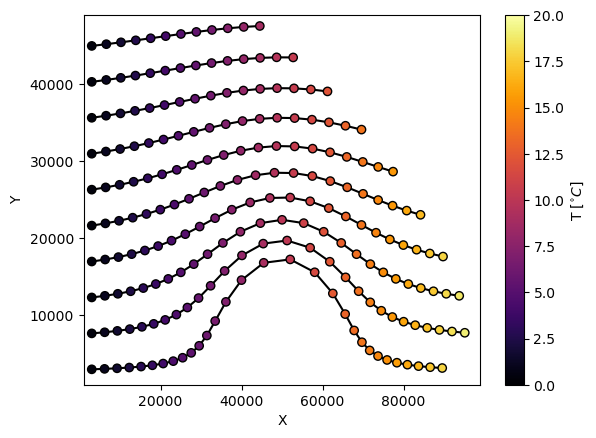

In [5]:
Particle_data = xr.open_zarr("SampleTemp.zarr")

plt.figure()
ax = plt.axes()
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.set_ylim(1000, 49000)
ax.set_xlim(1000, 99000)
ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c="k", zorder=1)
T_scatter = ax.scatter(
    Particle_data.lon,
    Particle_data.lat,
    c=Particle_data.temperature,
    cmap=plt.cm.inferno,
    norm=mpl.colors.Normalize(vmin=0.0, vmax=20.0),
    edgecolor="k",
    zorder=2,
)
plt.colorbar(T_scatter, label=r"T [$^{\circ} C$]")
plt.show()

## Sampling velocity fields


Because Parcels works also for generalised curvilinear grids, you need to tread somewhat carefully when wanting to sample the velocity fields `U` and `V`. In fact, Parcels will throw a warning when directly calling a sampling of either of these fields:


In [6]:
def SampleVel_wrong(particle, fieldset, time):
    u = fieldset.U[particle]


pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.Particle, lon=lon, lat=lat, time=time
)

pset.execute(SampleVel_wrong)

0it [00:00, ?it/s]


Instead, you should use the code `u, v = fieldset.UV[...]`. With this code, the sampling is consistent with the actual velocity fields used in the advection Kernels. The difference is that on a curvilinear grid, `fieldset.U[..]` returns the velocity in the `i`-direction (the columns on the grid), while `fieldset.UV[...]` returns the velocities in the longitude and latitude direction. Furthermore, only `fieldset.UV[...]` sampling can correctly deal with boundary conditions such as `freeslip` and `partialslip` ([documentation_unstuck_Agrid](https://docs.oceanparcels.org/en/latest/examples/documentation_unstuck_Agrid.html#3.-Slip-boundary-conditions))


In [7]:
def SampleVel_correct(particle, fieldset, time):
    u, v = fieldset.UV[particle]


pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.Particle, lon=lon, lat=lat, time=time
)

pset.execute(SampleVel_correct)

0it [00:00, ?it/s]


To sample U and V as part of a larger script the following code could be used:

In [8]:
SampleParticle = parcels.Particle.add_variables(
    [
        parcels.Variable("U", dtype=np.float32, initial=np.nan),
        parcels.Variable("V", dtype=np.float32, initial=np.nan),
    ]
)


def SampleVel_correct(particle, fieldset, time):
    # attention: samples particle velocity in units of the mesh (deg/s or m/s)
    particle.U, particle.V = fieldset.UV[
        time, particle.depth, particle.lat, particle.lon, particle
    ]

<div class="alert alert-info">

Note that the Kernels above return the value of `U` and `V` in the units of the grid. That means that for a spherical grid, the velocities are in **degrees/s**. To convert these to **m/s**, see the [UnitConversion tutorial](https://docs.oceanparcels.org/en/latest/examples/tutorial_unitconverters.html).
</div>

## Sampling initial values


In some simulations only the particles initial value within the field is of interest: the variable does not need to be known along the entire trajectory. To reduce computing we can specify the `to_write` argument to the temperature `Variable`. This argument can have three values: `True`, `False` or `'once'`. It determines whether to write the `Variable` to the output file. If we want to know only the initial value, we can enter `'once'` and only the first value will be written to the output file.


In [9]:
SampleParticleOnce = parcels.Particle.add_variable(
    "temperature", initial=0, to_write="once"
)

pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticleOnce, lon=lon, lat=lat, time=time
)

In [10]:
output_file = pset.ParticleFile(name="WriteOnce.zarr", outputdt=timedelta(hours=1))

pset.execute(
    [parcels.AdvectionRK4, SampleT],
    runtime=timedelta(hours=24),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in WriteOnce.zarr.
  0%|          | 0/86400.0 [00:00<?, ?it/s]

100%|██████████| 86400.0/86400.0 [00:03<00:00, 28126.13it/s]


Since all the particles are released at the same x-position and the temperature field is invariant in the y-direction, all particles have an initial temperature of 0.4$^\circ$C


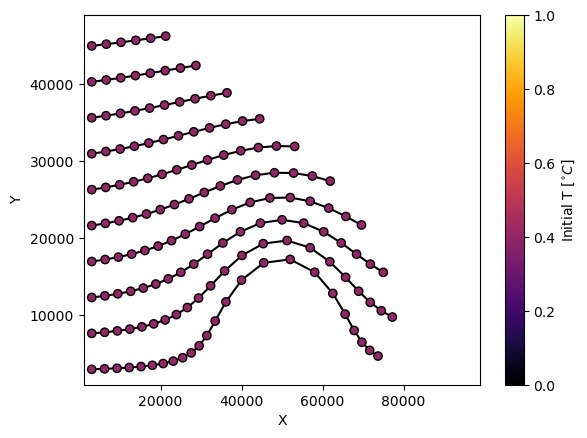

In [11]:
Particle_data = xr.open_zarr("WriteOnce.zarr")

plt.figure()
ax = plt.axes()
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.set_ylim(1000, 49000)
ax.set_xlim(1000, 99000)
ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c="k", zorder=1)
T_scatter = ax.scatter(
    Particle_data.lon,
    Particle_data.lat,
    c=np.tile(Particle_data.temperature, (Particle_data.lon.shape[1], 1)).T,
    cmap=plt.cm.inferno,
    norm=mpl.colors.Normalize(vmin=0.0, vmax=1.0),
    edgecolor="k",
    zorder=2,
)
plt.colorbar(T_scatter, label=r"Initial T [$^{\circ} C$]")
plt.show()